--------------------------------------------------------------------------------
***Niloufar Abbasi***

***401209996***

***تمرین دوم عملی از سری دوم تمرین ها***

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
# ***Unupervised Forward-Forward Algorithm:***
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

In [40]:
#required libraries:

import matplotlib.pyplot as plt
import numpy             as np
import os
import torch
import torchvision
import copy
import time
#-----------------------------------------------
from scipy.signal           import convolve2d
from sklearn.metrics        import accuracy_score
#-----------------------------------------------
from torch                  import nn
from torch                  import tensor
from torch                  import Tensor
from torch.optim            import Adam
from torch.optim            import Optimizer
from torch.utils.data       import DataLoader
from torch.utils.data       import Dataset
from torch.utils.data       import Subset
from torchvision            import datasets
from torchvision.datasets   import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import Lambda
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
from torch.nn               import Module
from torch.nn               import Linear
from torch.nn               import ReLU
from torch._jit_internal    import _copy_to_script_wrapper
#----------------------------------------------
from tqdm                   import tqdm
from typing                 import Iterator


# **(آ)**

# ***تعریف ماسک مناسب***


As discussed in the paper, one crucial aspect of unsupervised FF involves the generation of negative data. The objective is to create negative data with distinct long-range correlations but similar short-range correlations compared to positive examples. To achieve this, a mask is employed, leading to the creation of hybrid images that serve as effective negative examples.
The mask consists of regions containing fairly large sections of ones and zeros. The process involves creating hybrid images for negative data by combining a digit image with the mask and another digit image with the reverse of the mask, as illustrated in Figure 1 in the paper.

Mask Creation Process:
Masks with the desired characteristics can be generated through a specific procedure. Starting with a random binary image, the next step involves iteratively blurring the image with a filter of the form [1/4, 1/2, 1/4] in both the horizontal and vertical directions. Following repeated blurring, the resulting image is thresholded at 2 to obtain the final mask.

 # Note
The paper doesn't explicitly specify the number of times the image should be blurred

In [41]:
def create_mask(shape, iterations= 15): # shape(touple): the shape of the output mask (height,width)
                                        # iteration(int): the number of times to blure the image
                                        # Note that the paper doesn't explicitly specify the number of times the image should be blurred

    image = np.random.randint(0, 2, size=shape) # Create a random binary image

    blur_filter_1 = np.array(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)))  # as discussed in the paper
    blur_filter_2 = blur_filter_1.T

    for i in range(iterations):     # Blur the image with the specified filter
        image = np.abs(convolve2d(image, blur_filter_1, mode='same') / blur_filter_1.sum())
        image = np.abs(convolve2d(image, blur_filter_2, mode='same') / blur_filter_2.sum())

    mask = np.round(image).astype(np.uint8) # Binarize the blurred image, i.e. threshold it at 2.0

    return tensor(mask)

about the mode = 'same' (which I chose):

using **mode='same'** ensures that the blurred image retains the same size as the original image. This choice is relevant because the goal is to generate a mask with specific correlations that, when combined with digit images, produces hybrid images for negative data.

While the paper doesn't explicitly mention the choice of the convolution mode, using mode='same' is a common practice when the objective is to retain the original spatial dimensions of the input after convolution. It ensures that the blurring operation covers the entire input image and produces an output of the same size, facilitating subsequent steps in the described process.

--------------------------------------------------------------------------------
# **(ب)**  

# **تولید داده ی هیبرید**

as discussed in the paper :
We then create hybrid images for the negative data by adding together one digit image times the mask and a different digit image times the reverse of the mask as shown in figure

Create a negative image by combining two images with a binary mask.

*   image_1 (Tensor): The first  image to be combined.
*   image_2 (Tensor): The second image to be combined.
*   Tensor: The negative image created by combining the two input images.

In [42]:
#def create_hybrid_image(image_1, image_2):  #image_1: Tensor و #image_2: Tensor
#
#    assert image_1.shape == image_2.shape, "Incompatible images and mask shapes."
#    #  AssertionError: If the shapes of `image_1` and `image_2` are not the same.
#
#    mask = create_mask((image_1.shape[0], image_1.shape[1]))
#
#    image_1 = torch.mul(image_1, mask)
#    image_2 = torch.mul(image_2, (1 - mask))
#
#    return torch.add(image_1, image_2)


def create_hybrid_image(image_1, image_2):
    assert image_1.shape == image_2.shape, "Incompatible images and mask shapes."

    mask = create_mask((image_1.shape[0], image_1.shape[1])).to(image_1.device)

    image_1 = torch.mul(image_1, mask)
    image_2 = torch.mul(image_2, (1 - mask))

    return torch.add(image_1, image_2)


image_1.shape[0] and image_1.shape[1] are used to extract the height and width of image_1. The assumption here is that image_1 and image_2 have the same height and width, as indicated by the assertion statement. If the shapes are not the same, an AssertionError is raised.

<Figure size 640x480 with 0 Axes>

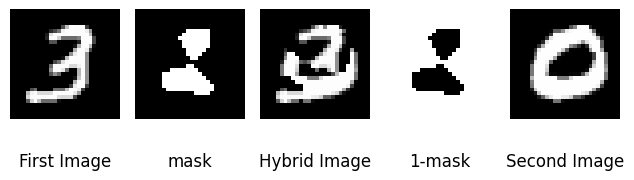

In [43]:
# generating and visualizing hybrid images using the MNIST dataset.

mnist = torchvision.datasets.MNIST(root='data/', download=True) # Load the MNIST dataset

image_1, _ = mnist[np.random.randint(len(mnist))]        #random instances of images from the MNIST dataset
image_2, _ = mnist[np.random.randint(len(mnist))]        #random instances of images from the MNIST dataset

image_1 = torch.as_tensor(np.asarray(image_1))           #images are then converted to PyTorch tensors
image_2 = torch.as_tensor(np.asarray(image_2))

mask = create_mask((28, 28))                             # mask
hybrid_image = create_hybrid_image(image_1, image_2)     # hybrid image

plt.figure()

# Create the subplot
fig, ax = plt.subplots(1, 5)
images = [image_1, mask, hybrid_image, 1 - mask, image_2]
names = ["First Image", "mask", "Hybrid Image", "1-mask", "Second Image"]
# Add the images to the subplot
for i, image in enumerate(images):
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(names[i], y=-0.5)

# Show the subplot
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
# **(ج و د)**
# **پیاده سازی شبکه**
# **پیاده سازی طبقه بند خطی**

In [44]:
def goodness_score(pos_acts, neg_acts, threshold=2):
    pos_goodness = -torch.sum(torch.pow(pos_acts, 2)) + threshold
    neg_goodness = torch.sum(torch.pow(neg_acts, 2)) - threshold
    return torch.add(pos_goodness, neg_goodness)

goodness_score function computes a goodness score based on positive andnegative activations.

In [45]:
def create_negative_batch(images: Tensor):
    neg_imgs = []
    batch_size = images.shape[0]
    for _ in range(batch_size):
        idx1, idx2 = np.random.randint(batch_size, size=2)
        neg_imgs.append(create_hybrid_image(images[idx1].squeeze(), images[idx2].squeeze()))
    return torch.unsqueeze(torch.stack(neg_imgs), dim=1)

Implements a function create_negative_batch to generate a batch of negative images by combining pairs of random images from the dataset.

In [46]:
def prepare_data():
    # data transformation pipeline
    transform = Compose([
            ToTensor()                      ,    # Convert image to tensor
            Normalize((0.1307,), (0.3081,)) ,    # Normalize the tensor with mean (0.1307) and standard deviation (0.3081)
            ]) # flatenning
#===================================================

    # Load the train MNIST dataset
    # Load training data
    training_data = datasets.MNIST(
        root      = "data"    ,                  # directory to store the dataset
        train     = True      ,                  # training set
        download  = True      ,                  # Download the dataset
        transform = transform )                  # aapply the defined transformation

    n_train_samples = len(training_data)

    # Load test data
    test_data = datasets.MNIST(
        root      = "data"    ,                  # directory to store the dataset
        train     = False     ,                  # test set
        download  = True      ,                  # download yhe dataset
        transform = transform )                  # apply the transformation

    if not os.path.exists("transformed_dataset.pt"):
        random_pairs = np.random.randint(n_train_samples, size=[n_train_samples, 2])
        random_pairs = [(row[0], row[1]) for row in random_pairs]

        # Transform the data
        transformed_dataset = [
            create_hybrid_image(training_data[pair[0]][0].squeeze(), training_data[pair[1]][0].squeeze())
            for pair in tqdm(random_pairs)]

        # Save the transformed images to a folder
        torch.save(transformed_dataset, 'transformed_dataset.pt')


here the code Sets up a data transformation pipeline using the torchvision.transforms.Compose class.
Loads the MNIST dataset for training and testing.
If the transformed dataset file doesn't exist, creates random pairs of images and generates transformed images, saving them to a file.

In [47]:
def get_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    return dict(accuracy_score=acc)

    '''
    Calculates the accuracy of the model's predictions. The accuracy_score function is used here, which is
    typically provided by a machine learning library, sk-learn.
    It compares the predicted labels (preds) with the true labels (labels) and computes the accuracy.
    '''

In [48]:
class FF_Layer(nn.Linear):                       #inherits from the PyTorch nn.Linear class
    def __init__(self, in_features, out_features, n_epochs, bias, device):
        super().__init__(in_features, out_features, bias=bias)
        self.n_epochs = n_epochs
        self.opt      = torch.optim.Adam(self.parameters())
        self.goodness = goodness_score
        self.to(device)
        self.ln_layer = nn.LayerNorm(normalized_shape=[1, out_features]).to(device)
    #---------------------------------------------------------------------------
    def ff_train(self, pos_acts, neg_acts):

        #Train the layer using positive and negative activations.
        #pos_acts (numpy.ndarray): Numpy array of positive activations.
        #neg_acts (numpy.ndarray): Numpy array of negative activations.

        self.opt.zero_grad()                                      ## Set optimizer gradients to zero
        goodness = self.goodness(pos_acts, neg_acts)              #Compute the goodness score using the provided function
        goodness.backward()
        self.opt.step()                                           # update the optimizer based on the computed gradient
    #---------------------------------------------------------------------------
    def forward(self, input):                                     # performa forward pass through the layer and apply layer normalization
        input = super().forward(input)                            #call the forward method of the parent class (nn.Linear)
        input = self.ln_layer(input.detach())                     # Apply layer normalization to the input
        return input


The code I've written Defines a custom feedforward layer FF_Layer as a subclass of nn.Linear. Implements methods for training the layer and applying layer normalization during the forward pass.

In [49]:
class Unsupervised_FF(nn.Module):
    def __init__(self, n_layers= 4, n_neurons=2000, input_size = 28 * 28, n_epochs = 100, threshold = 2.0,
                 bias: bool = True, n_classes= 10, n_hid_to_log = 3, device=torch.device("cuda:0")):
        super().__init__()
        self.n_hid_to_log = n_hid_to_log
        self.n_epochs     = n_epochs
        self.device       = device

        # Create a list of FF_Layer instances for the feedforward layers
        ff_layers = [
            FF_Layer(in_features  = input_size if idx == 0 else n_neurons ,
                     out_features = n_neurons                             ,
                     n_epochs     = n_epochs                              ,
                     bias         = bias                                  ,
                     device       = device) for idx in range(n_layers)]

        self.ff_layers  = ff_layers
        self.last_layer = nn.Linear(in_features=n_neurons * n_hid_to_log, out_features=n_classes, bias=bias)
        self.to(device)
        self.opt        = torch.optim.Adam(self.last_layer.parameters())
        self.loss       = torch.nn.CrossEntropyLoss(reduction="mean")
    #---------------------------------------------------------------------------
    def train_ff_layers(self, pos_dataloader, neg_dataloader):
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training FF Layers", position=0)
        threshold=2.0
        for epoch in outer_tqdm:
            inner_tqdm = tqdm(zip(pos_dataloader, neg_dataloader), desc=f"Training FF Layers | Epoch {epoch}",
                              leave=False, position=1)
            for pos_data, neg_imgs in inner_tqdm:
                pos_imgs, _  = pos_data
                pos_acts     = torch.reshape(pos_imgs, (pos_imgs.shape[0], 1, -1)).to(self.device)
                neg_acts     = torch.reshape(neg_imgs, (neg_imgs.shape[0], 1, -1)).to(self.device)
                #loss = torch.log(1+ torch.exp(torch.cat([-torch.sum(torch.pow(pos_acts, 2)) + threshold,torch.sum(torch.pow(neg_acts, 2)) - threshold]))).mean()
                for idx, layer in enumerate(self.ff_layers):
                    pos_acts = layer(pos_acts)
                    neg_acts = layer(neg_acts)
                    layer.ff_train(pos_acts, neg_acts)
    #---------------------------------------------------------------------------
    def train_last_layer(self, dataloader):
        num_examples = len(dataloader)
        outer_tqdm   = tqdm(range(self.n_epochs), desc="Training Last Layer", position=0)
        loss_list    = []
        for epoch in outer_tqdm:
            epoch_loss = 0
            inner_tqdm = tqdm(dataloader, desc=f"Training Last Layer | Epoch {epoch}", leave=False, position=1)
            for images, labels in inner_tqdm:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.opt.zero_grad()
                preds  = self(images)
                # Compute the loss
                loss   = self.loss(preds, labels)
                epoch_loss += loss
                loss.backward()
                self.opt.step()
            loss_list.append(epoch_loss / num_examples)
            # Update progress bar with current loss
        return [l.detach().cpu().numpy() for l in loss_list]
    #---------------------------------------------------------------------------
    def forward(self, image):
        image = image.to(self.device)
        image = torch.reshape(image, (image.shape[0], 1, -1))
        concat_output = []
        for idx, layer in enumerate(self.ff_layers):
            image = layer(image)
            if idx > len(self.ff_layers) - self.n_hid_to_log - 1:
                concat_output.append(image)
        concat_output = torch.concat(concat_output, 2)
        logits = self.last_layer(concat_output)
        return logits.squeeze()
    #---------------------------------------------------------------------------
    def evaluate(self, dataloader, dataset_type= "train"):
        self.eval()
        inner_tqdm = tqdm(dataloader, desc=f"Evaluating model", leave=False, position=1)
        all_labels = []
        all_preds  = []
        for images, labels in inner_tqdm:
            images = images.to(self.device)
            labels = labels.to(self.device)
            preds  = self(images)
            preds  = torch.argmax(preds, 1)
            all_labels.append(labels.detach().cpu())
            all_preds.append(preds.detach().cpu())
        all_labels = torch.concat(all_labels, 0).numpy()
        all_preds  = torch.concat(all_preds, 0).numpy()
        metrics_dict = get_metrics(all_preds, all_labels)
        print(f"{dataset_type} dataset scores: ", "\n".join([f"{key}: {value}" for key, value in metrics_dict.items()]))

In [50]:
def train(model, pos_dataloader, neg_dataloader):
    model.train()
    model.train_ff_layers(pos_dataloader, neg_dataloader)
    return model.train_last_layer(pos_dataloader)

Unsupervised Feedforward Neural Network :

Defines a class Unsupervised_FF that represents the unsupervised feature learning model.
Initializes the model with a specified number of layers, neurons, epochs, and other parameters.
Contains methods for training the feedforward layers and the last layer separately, as well as evaluating the model on a dataset.
Utilizes the custom FF_Layer class for the feedforward layers.


Finally, trains the last layer using a provided dataloader.

--------------------------------------------------------------------------------
# **(ه)**
# **گزارش نتایج**

Training FF Layers:   0%|          | 0/7 [00:00<?, ?it/s]
Training FF Layers | Epoch 0: 0it [00:00, ?it/s]
Training FF Layers | Epoch 0: 3it [00:00, 24.31it/s]
Training FF Layers | Epoch 0: 6it [00:00, 26.28it/s]
Training FF Layers | Epoch 0: 9it [00:00, 27.30it/s]
Training FF Layers | Epoch 0: 13it [00:00, 29.28it/s]
Training FF Layers | Epoch 0: 17it [00:00, 30.06it/s]
Training FF Layers | Epoch 0: 20it [00:00, 29.07it/s]
Training FF Layers | Epoch 0: 23it [00:00, 28.52it/s]
Training FF Layers | Epoch 0: 26it [00:01, 23.38it/s]
Training FF Layers | Epoch 0: 29it [00:01, 22.81it/s]
Training FF Layers | Epoch 0: 32it [00:01, 22.67it/s]
Training FF Layers | Epoch 0: 35it [00:01, 22.70it/s]
Training FF Layers | Epoch 0: 40it [00:01, 28.70it/s]
Training FF Layers | Epoch 0: 45it [00:01, 33.18it/s]
Training FF Layers | Epoch 0: 49it [00:01, 31.29it/s]
Training FF Layers | Epoch 0: 54it [00:01, 34.50it/s]
Training FF Layers | Epoch 0: 59it [00:01, 37.23it/s]
Training FF Layers | Epoch 0: 64

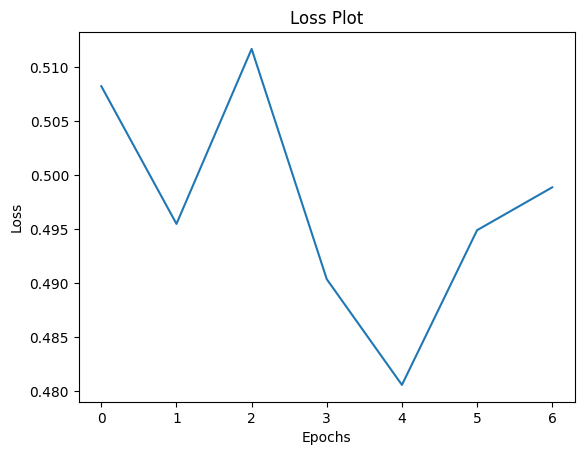


Evaluating model:  99%|█████████▉| 933/938 [00:11<00:00, 72.71it/s]
                                                                   

Train dataset scores:  accuracy_score: 0.9075



Evaluating model:  96%|█████████▌| 150/157 [00:02<00:00, 83.40it/s]
                                                                   

Test dataset scores:  accuracy_score: 0.8982


In [53]:
def plot_loss(loss):
    # plot the loss over epochs
    fig = plt.figure()
    plt.plot(list(range(len(loss))), loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.savefig("Loss Plot.png")
    plt.show()


if __name__ == '__main__':
    prepare_data()

    # Load the MNIST dataset
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    pos_dataset = torchvision.datasets.MNIST(root='./', download=True, transform=transform, train=True)
    # pos_dataset = Subset(pos_dataset, list(range(1000)))
    # Create the data loader
    pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=2)

    # Load the transformed images
    neg_dataset = torch.load('transformed_dataset.pt')
    # Create the data loader
    neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=2)

    # Load the test images
    test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)
    # Create the data loader
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

    device = torch.device("cuda:0")
    unsupervised_ff = Unsupervised_FF(device=device, n_epochs=7)

    loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

    plot_loss(loss)

    unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
    unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")

In the results of the last cell of the code, as we observe, our model achieves good accuracy—approximately 0.9 on the training data and around 0.88 on the test data after 10 epochs of learning.

Explanations about the implementation are written in comments in code cells or in markdowns in text cells.